# Import libraries

In [17]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
import numpy as np
import cv2
import tensorflow as tf

# Models arch

In [12]:
def create_gray_model(num_of_characters):
    '''

    This is the architecture of gray OCR model.    

    '''
    input_data = Input(shape=(256, 64, 1), name='input')

    inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

    inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
    inner = Dropout(0.2)(inner)

    inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
    inner = Dropout(0.2)(inner)

    target = inner.shape

    # CNN to RNN
    inner = Reshape(target_shape=((target[1], target[2]*target[3])), name='reshape')(inner)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

    ## RNN
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
    inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

    ## OUTPUT
    inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
    y_pred = Activation('softmax', name='softmax')(inner)

    model = Model(inputs=input_data, outputs=y_pred)

    return model

# Instantiate

In [13]:
model = create_gray_model(121)
model.load_weights("../models/pracalit/gray/best_model.keras")

# Get dictionaries

In [28]:
with open("../models/pracalit/gray/pracalit_dict.txt","r") as f:
    char_dict = f.readline()
char_dict += " "

# Encoding

In [30]:
def label_to_num(label, char_dict):
    '''

        Convert labels to numerical value with respect to character dict.
    
    '''
    label_num = []
    for ch in label:
        label_num.append(char_dict.find(ch)) 
        #find() method returns the lowest index of the substring if it is found in given string otherwise -1
        
    return np.array(label_num)

def num_to_label(num, char_dict):
    '''

        Convert numerical value to labels with respect to character dict.
    
    '''
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=char_dict[ch]
    return ret

# Image

In [31]:
def preprocess_for_gray_channel(img):
    '''
    
        Preprocess for gray_channel.

    '''
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    target_shape = (64, 256)

    # Resize and convert to array
    resized_image = cv2.resize(img, (target_shape[1], target_shape[0]))
    rotated_image = cv2.rotate(resized_image, cv2.ROTATE_90_CLOCKWISE)
    image_arr = np.array(rotated_image).reshape(-1,256,64,1)
    image_arr = image_arr/255

    return image_arr

In [32]:
image_arr = preprocess_for_gray_channel(cv2.imread("../test_data/pracalit/gray/1.png"))

In [42]:
preds = model.predict(image_arr, verbose=False)

# Define input_length for CTC decoding
input_length = np.ones(preds.shape[0]) * preds.shape[1]  # Same length for all sequences

# Convert numpy arrays to TensorFlow tensors
preds_tensor = tf.convert_to_tensor(preds, dtype=tf.float32)
input_length_tensor = tf.convert_to_tensor(input_length, dtype=tf.int32)


# Perform CTC decoding
decoded, _ = tf.keras.backend.ctc_decode(preds_tensor, input_length=input_length_tensor, greedy=True)

# Extract the decoded values
decoded_np = decoded[0].numpy()  # Convert tensor to numpy array

# Assuming num_to_label is a function that maps label indices to strings
prediction = [num_to_label(decoded_np[i], char_dict) for i in range(preds.shape[0])]
pred_str = "".join(prediction)
print(pred_str)

𑐳𑐘𑑓𑐔𑐵𑐬 ,



# Visualize

In [48]:
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'dense' in layer.name or 'lstm' in layer.name]

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

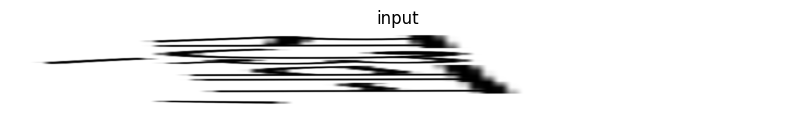

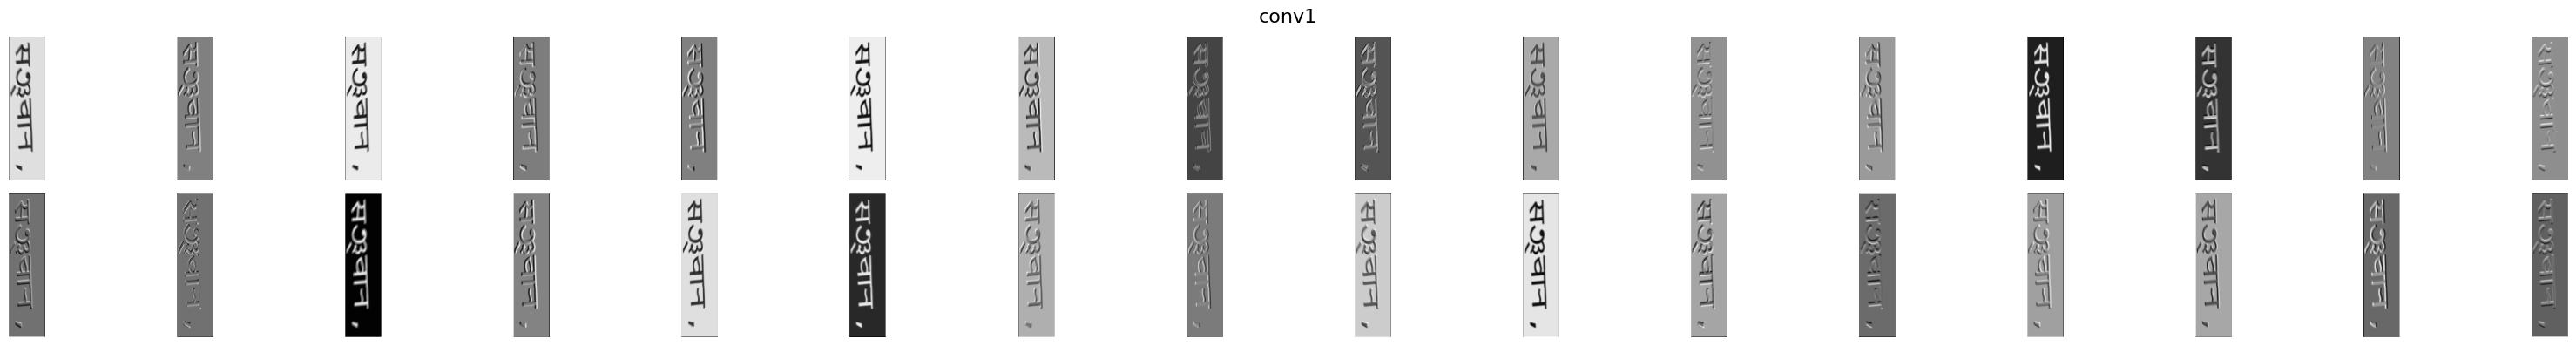

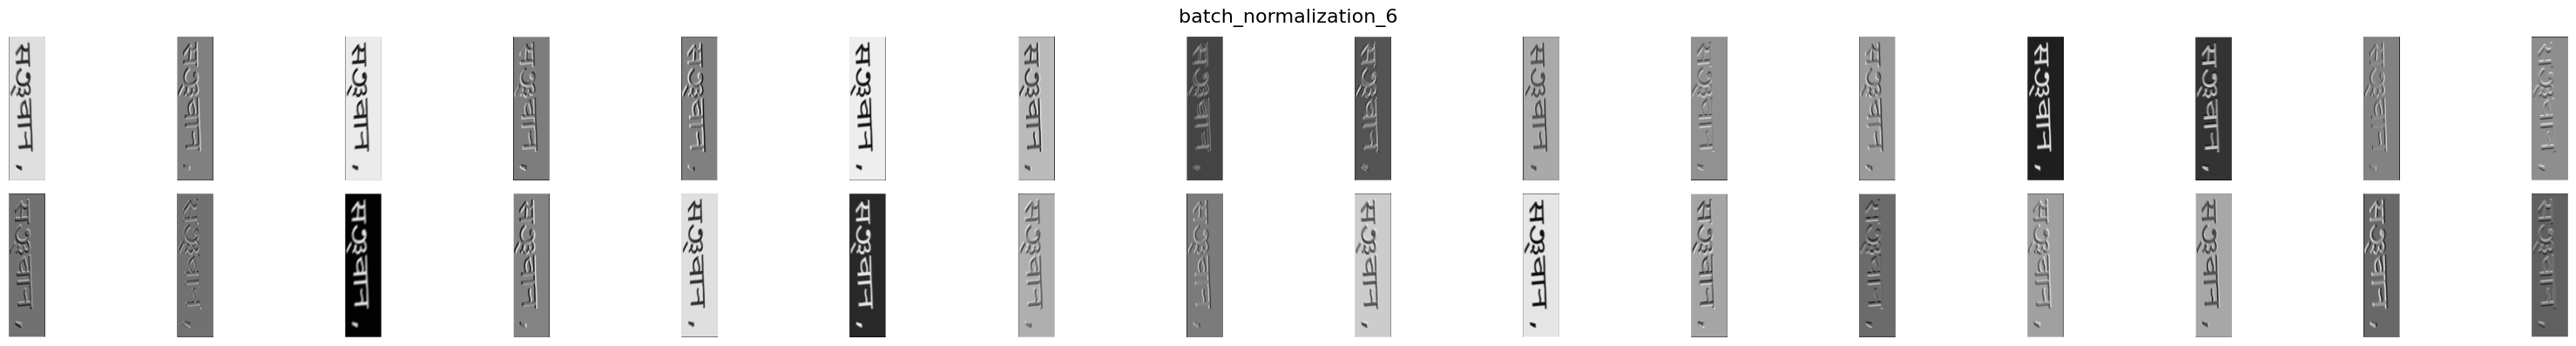

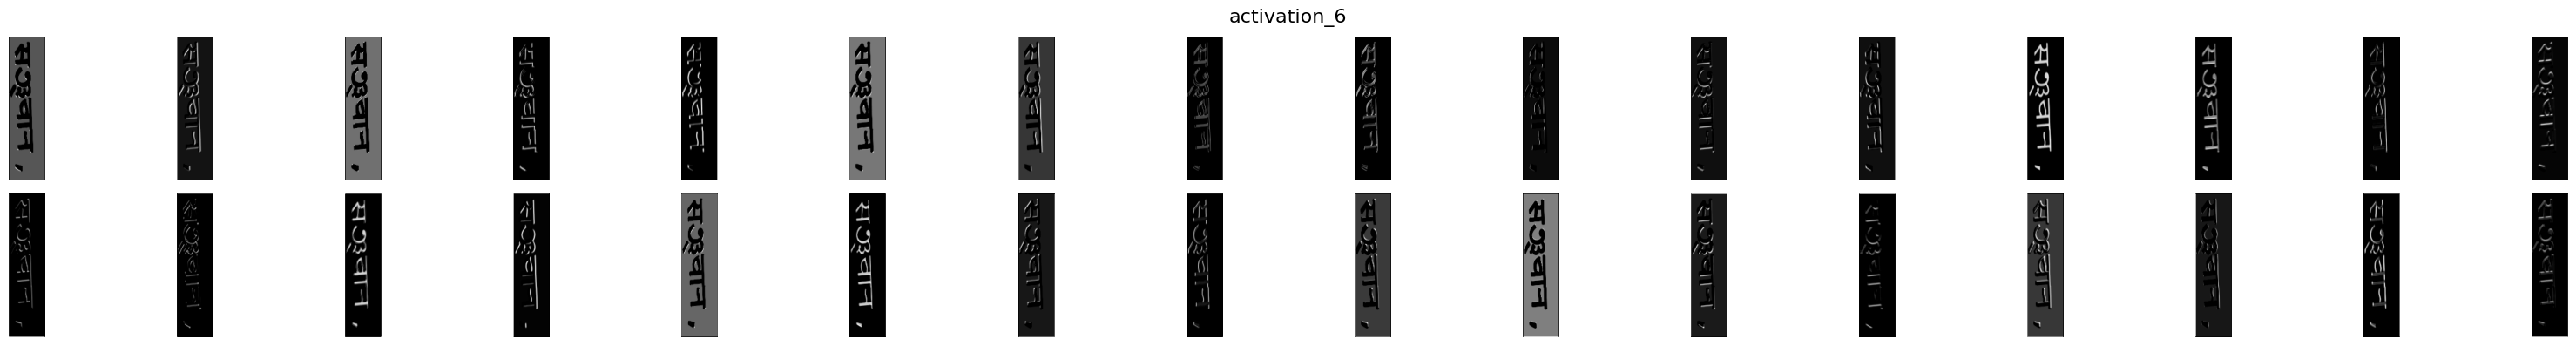

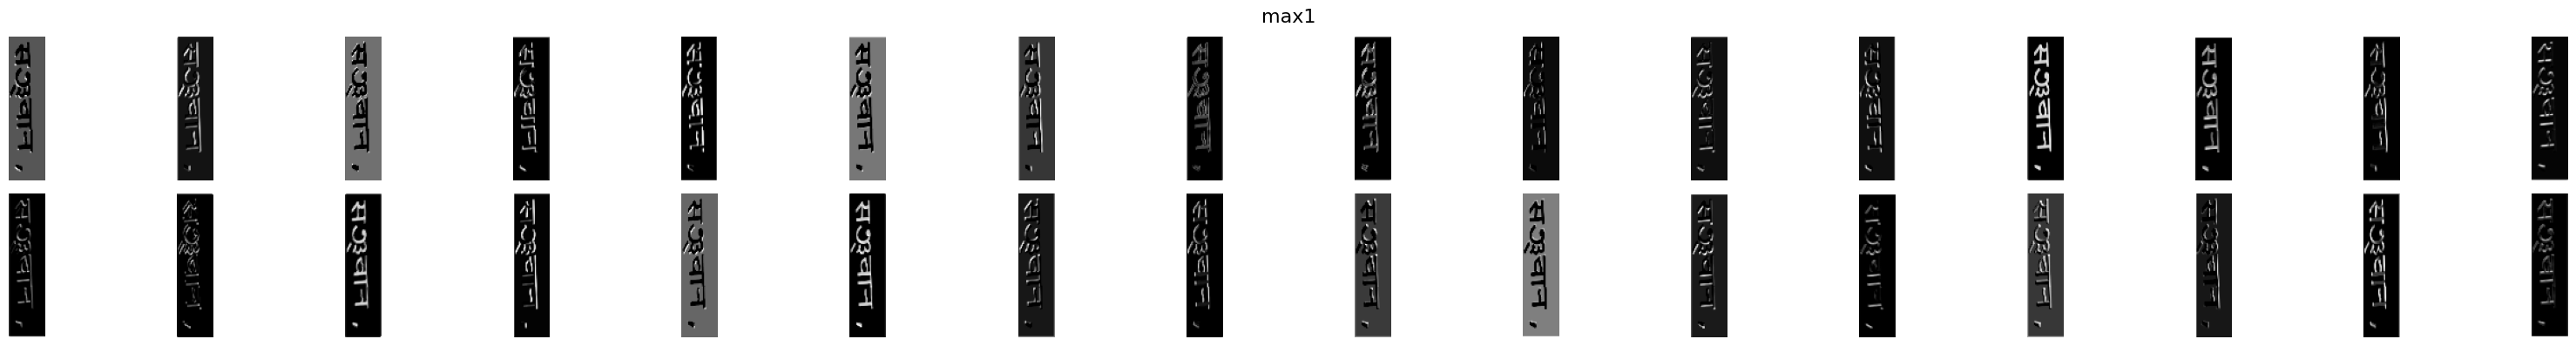

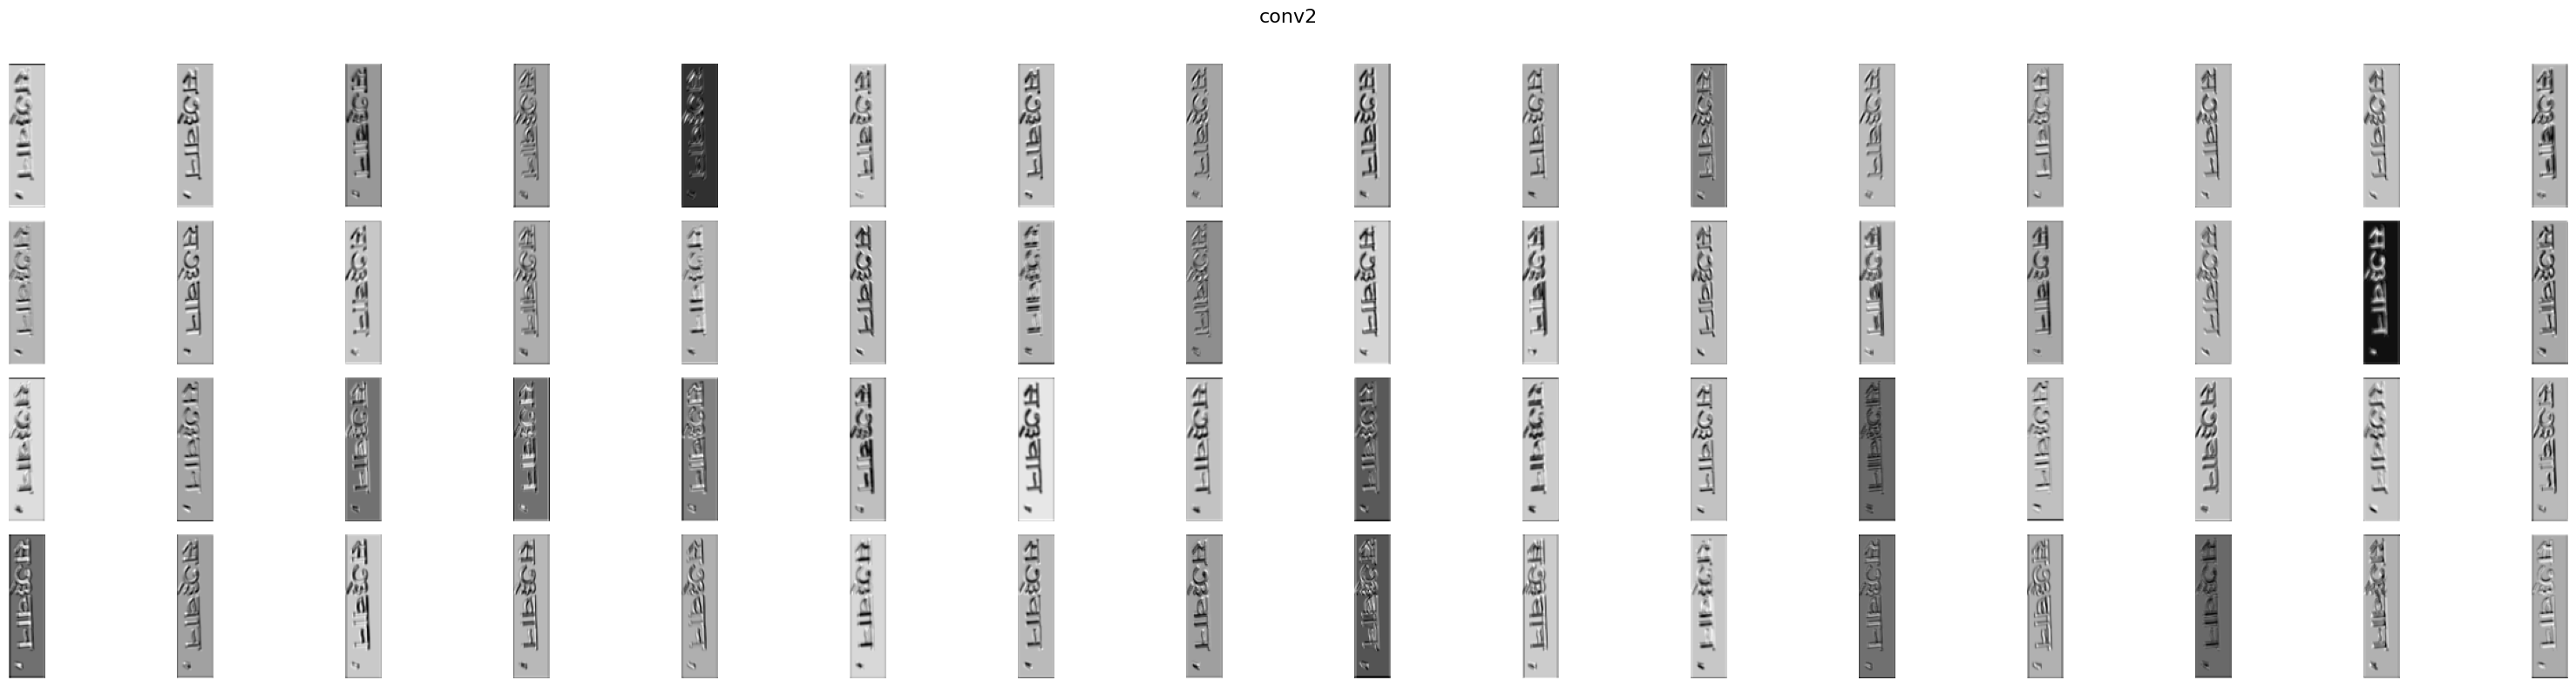

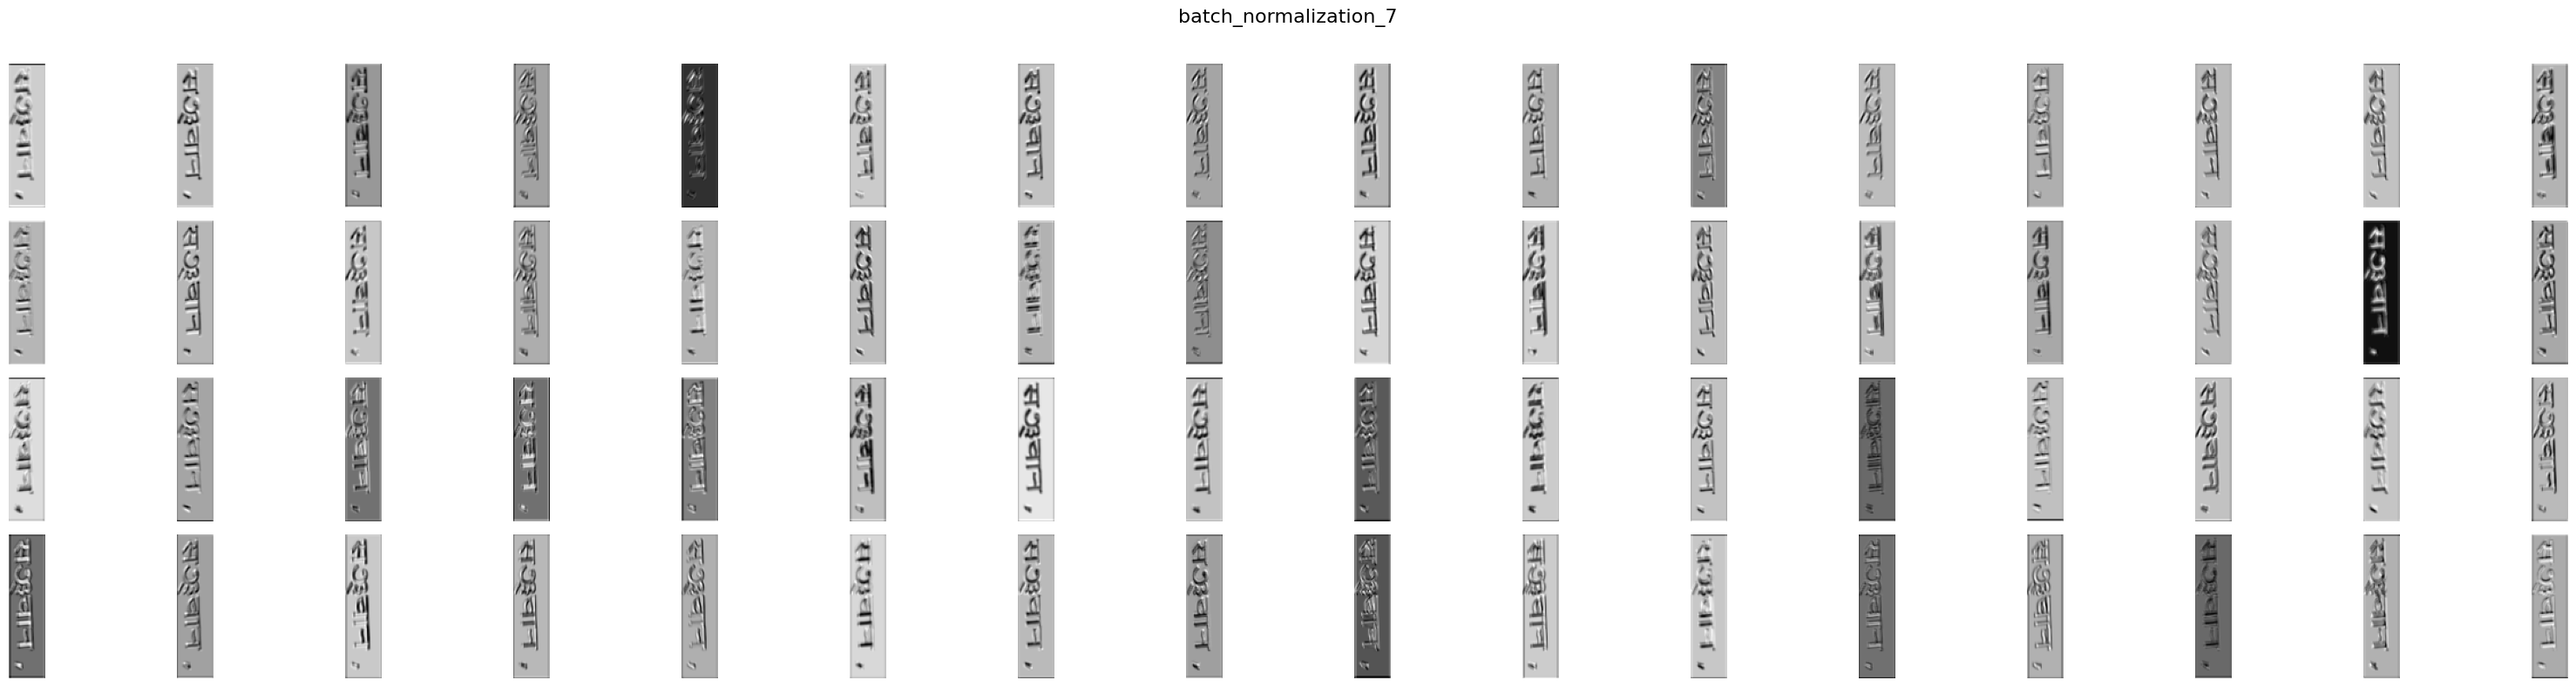

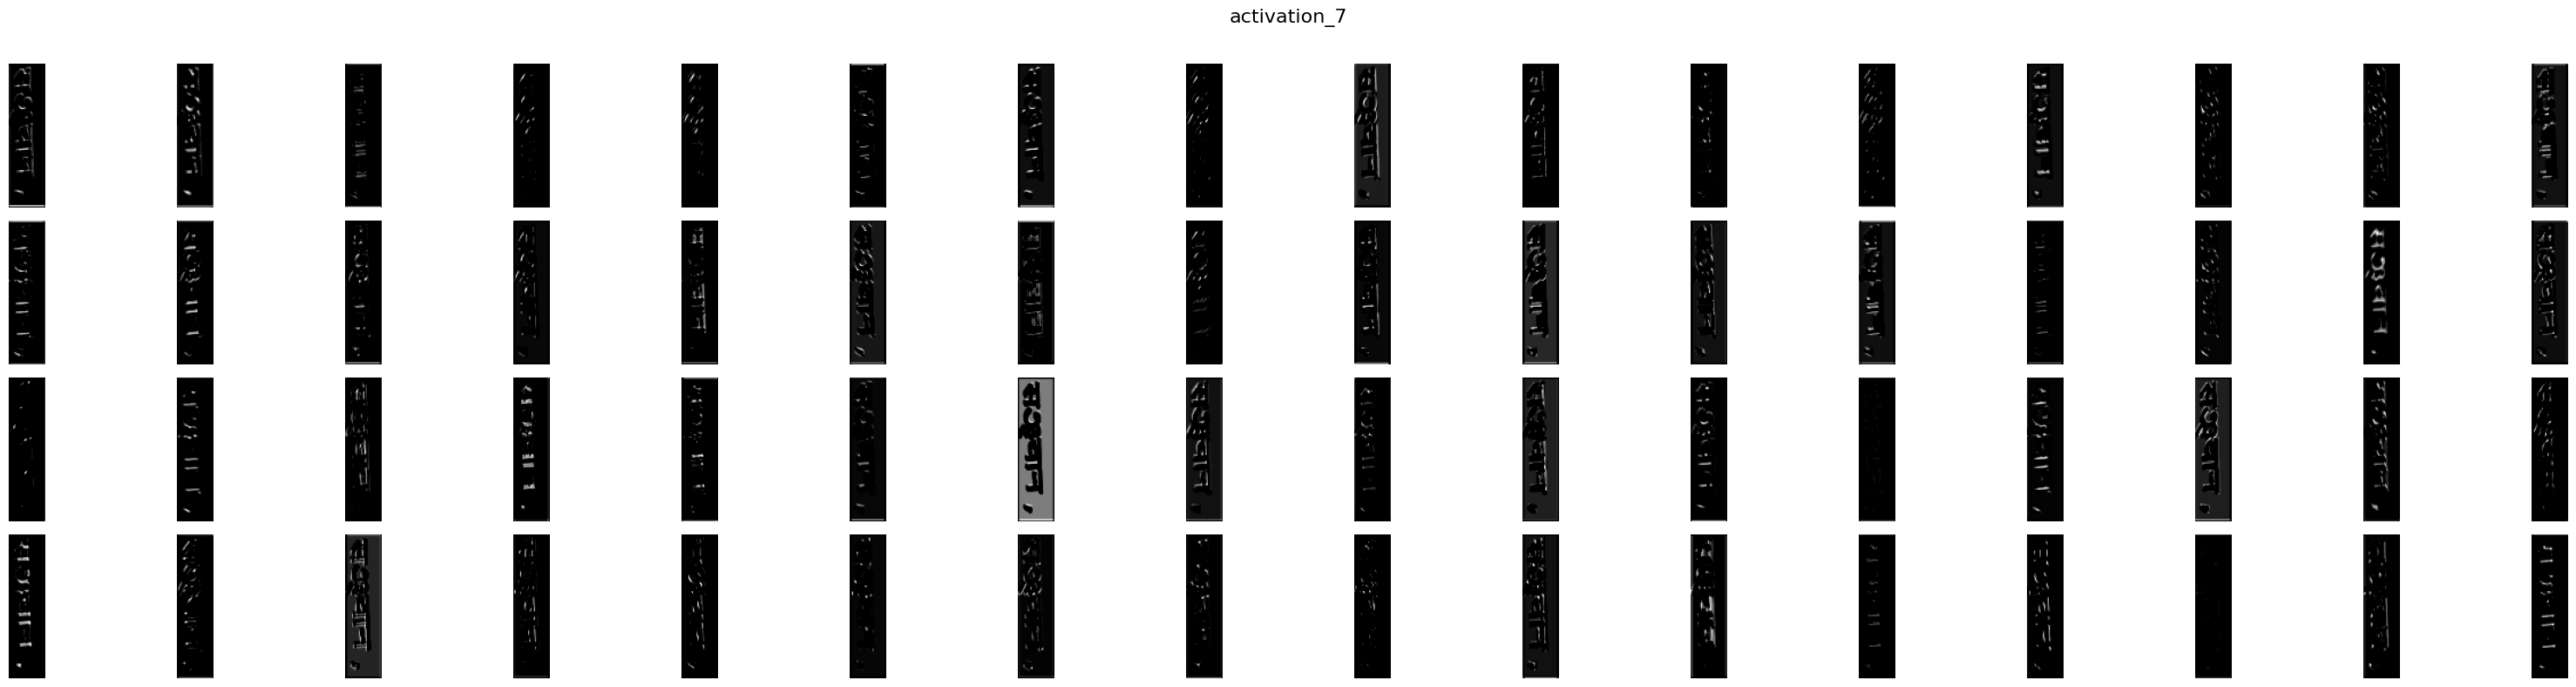

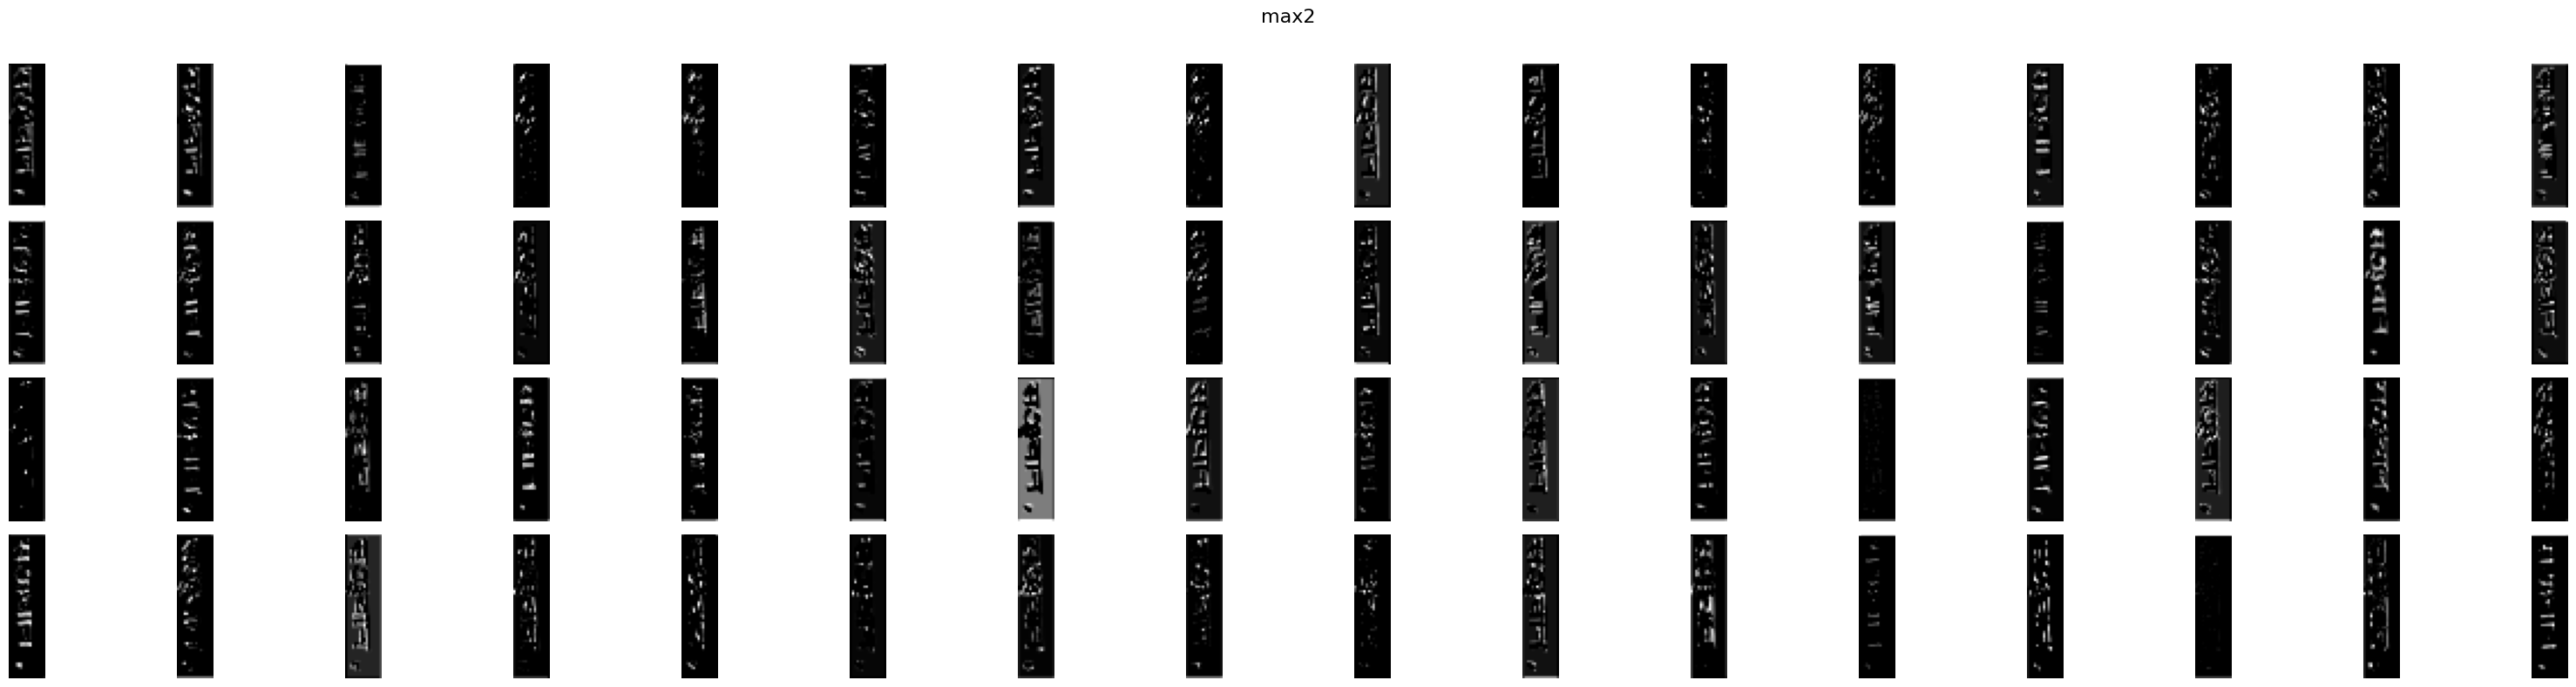

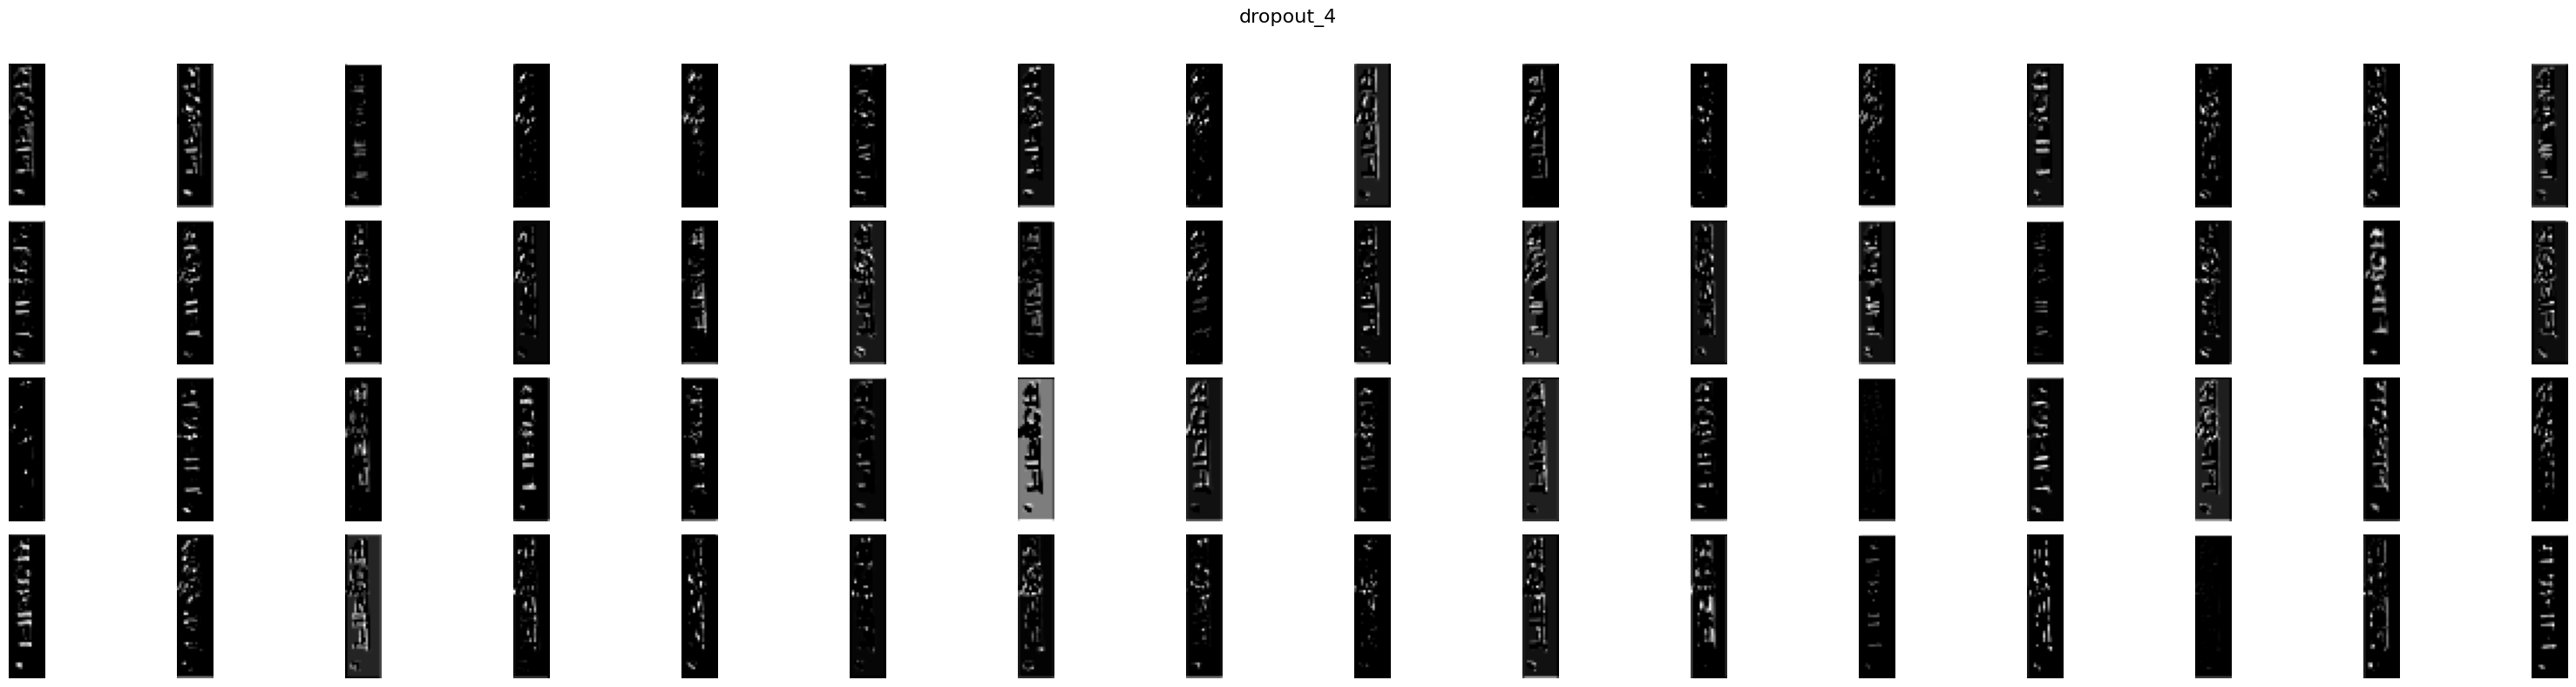

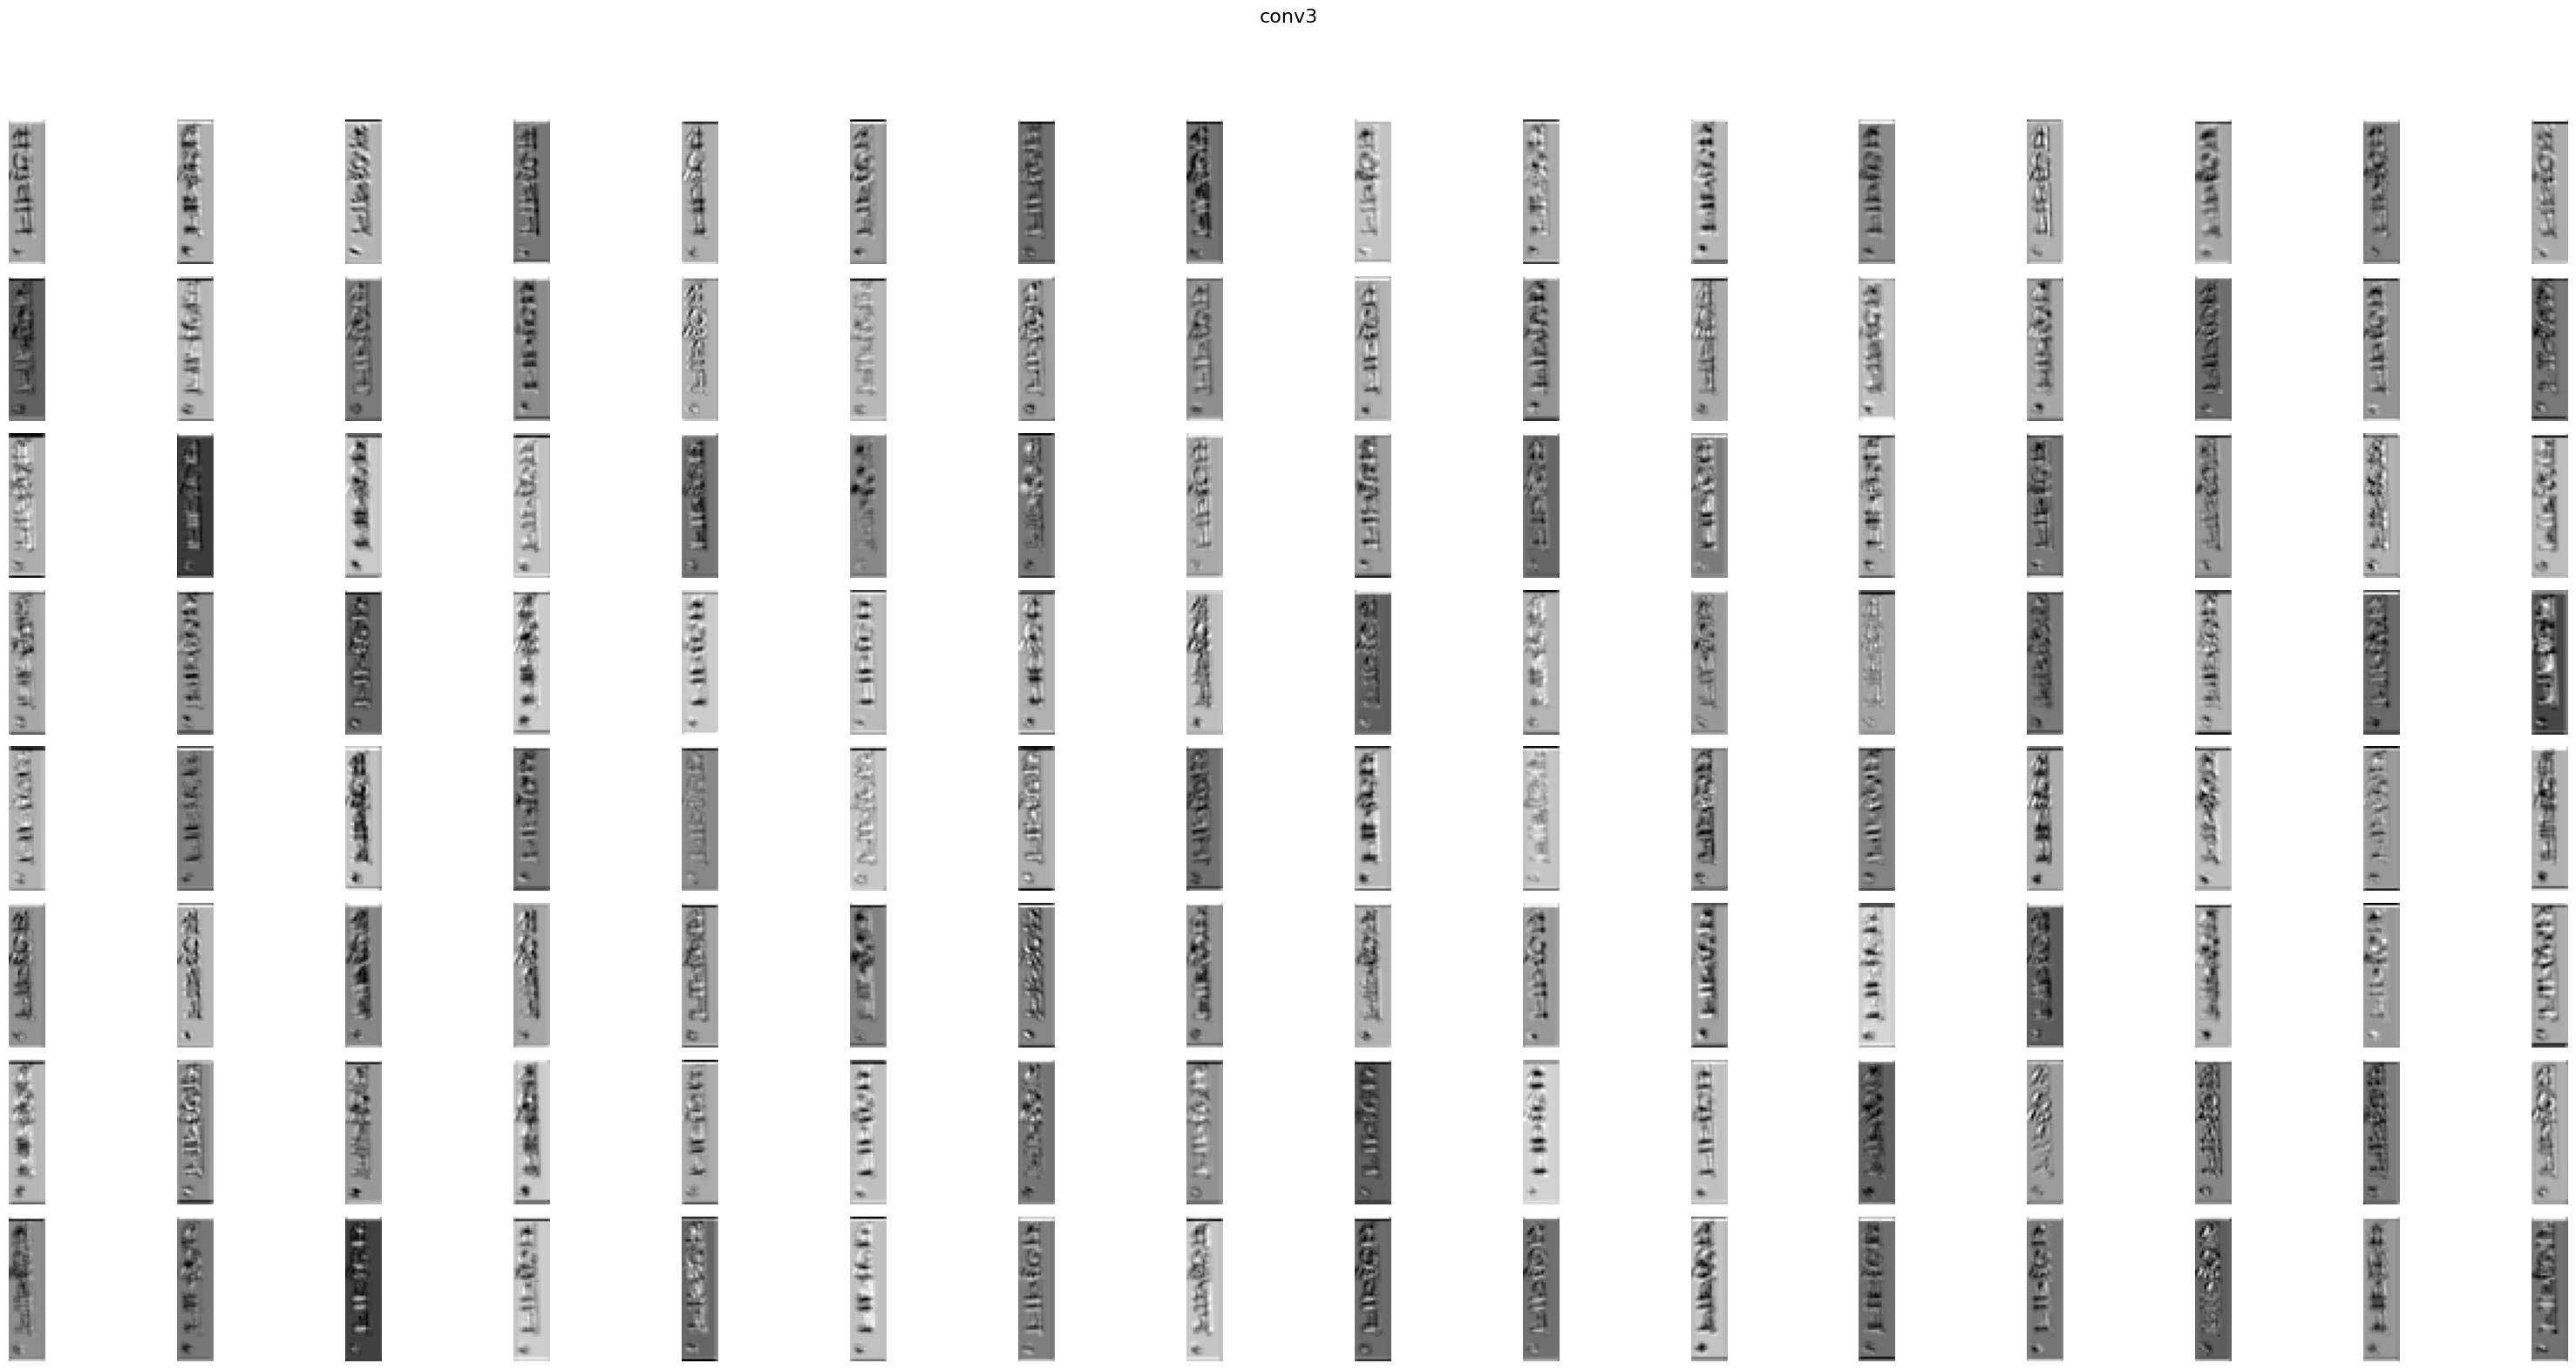

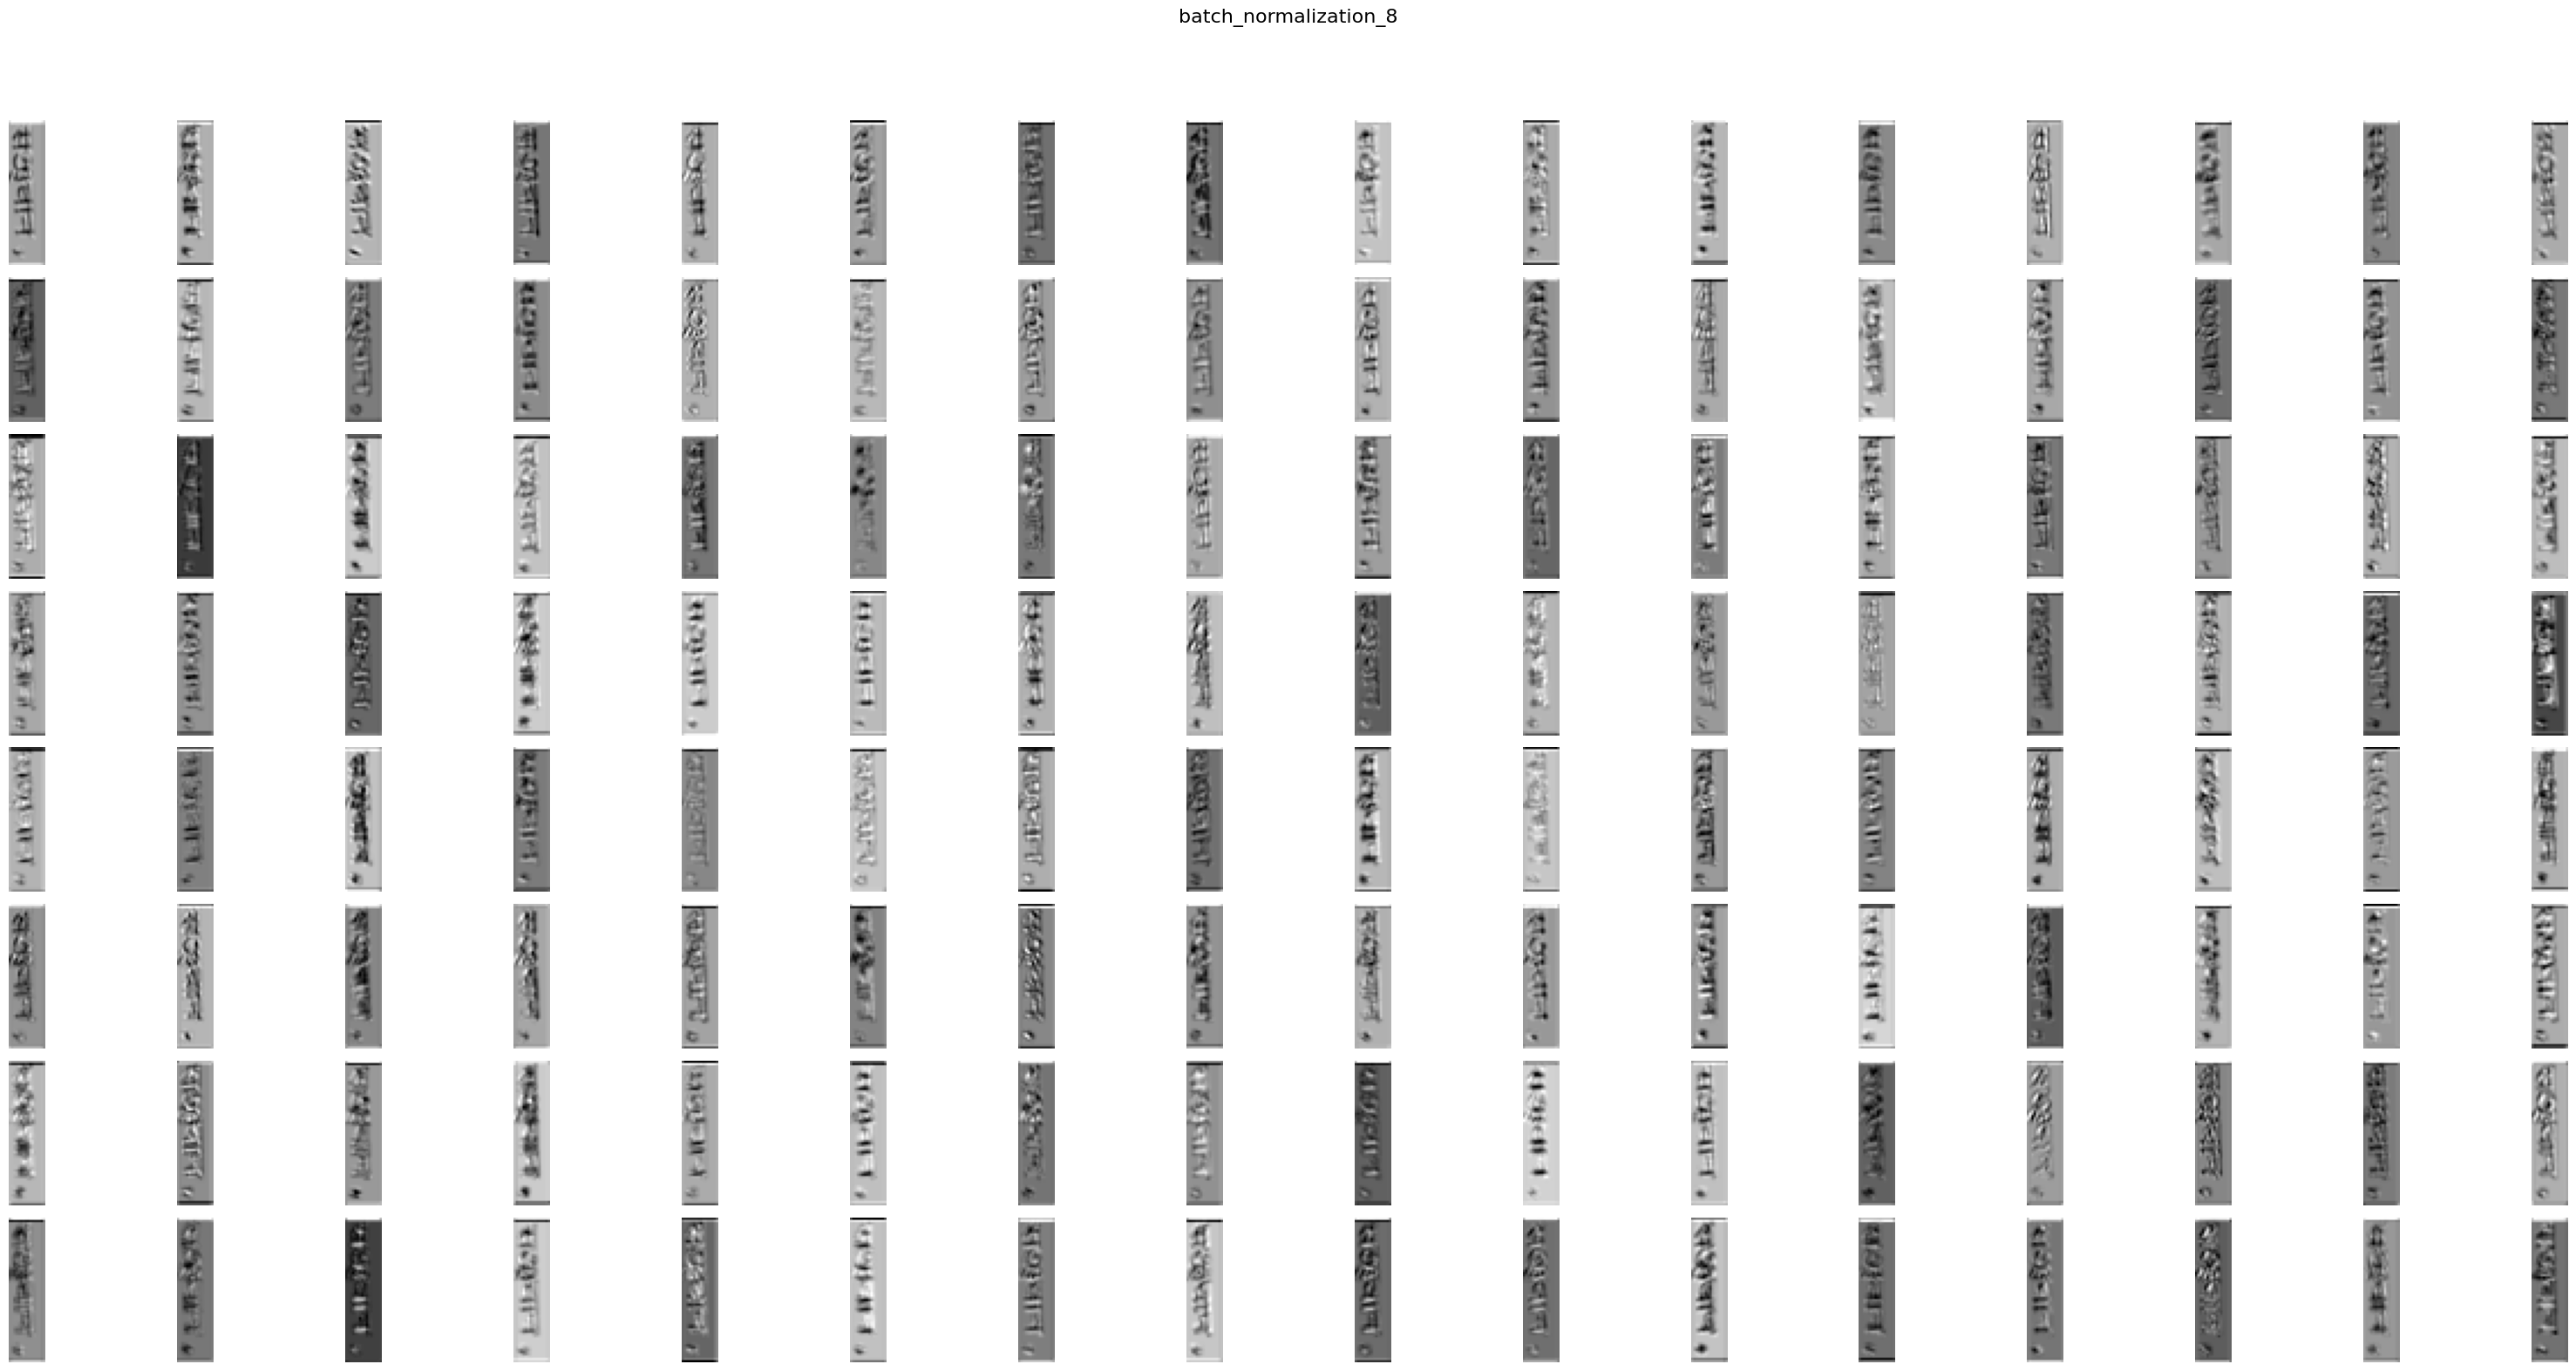

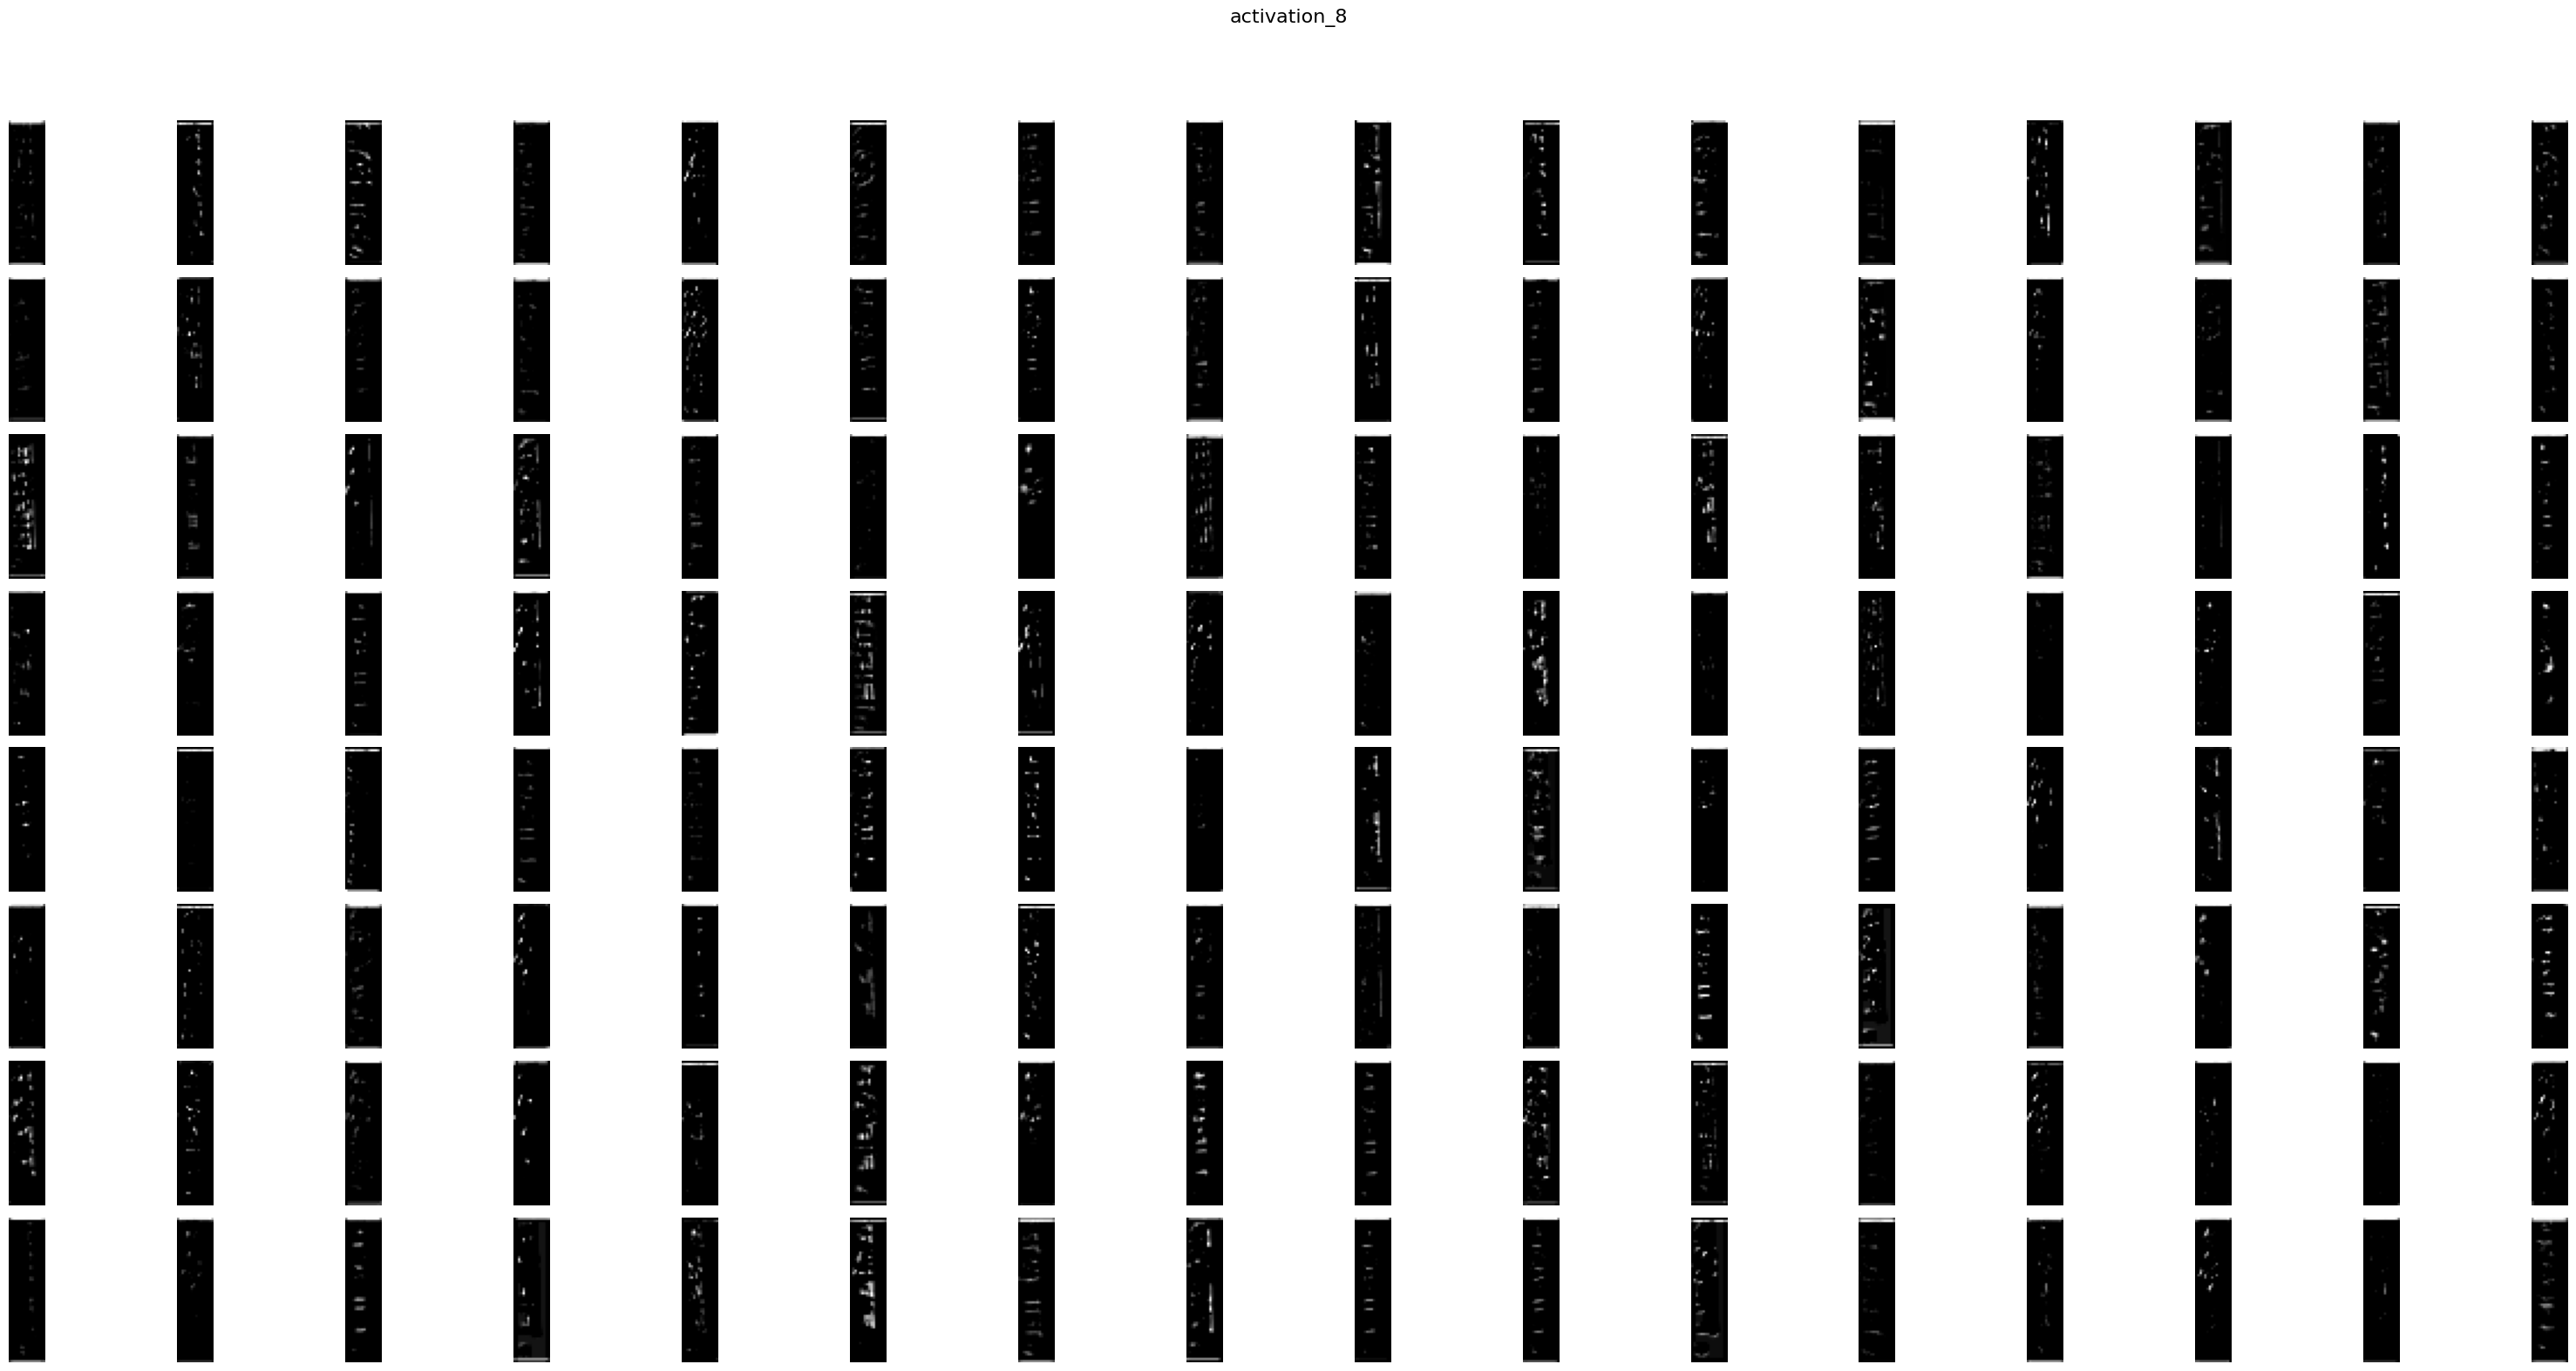

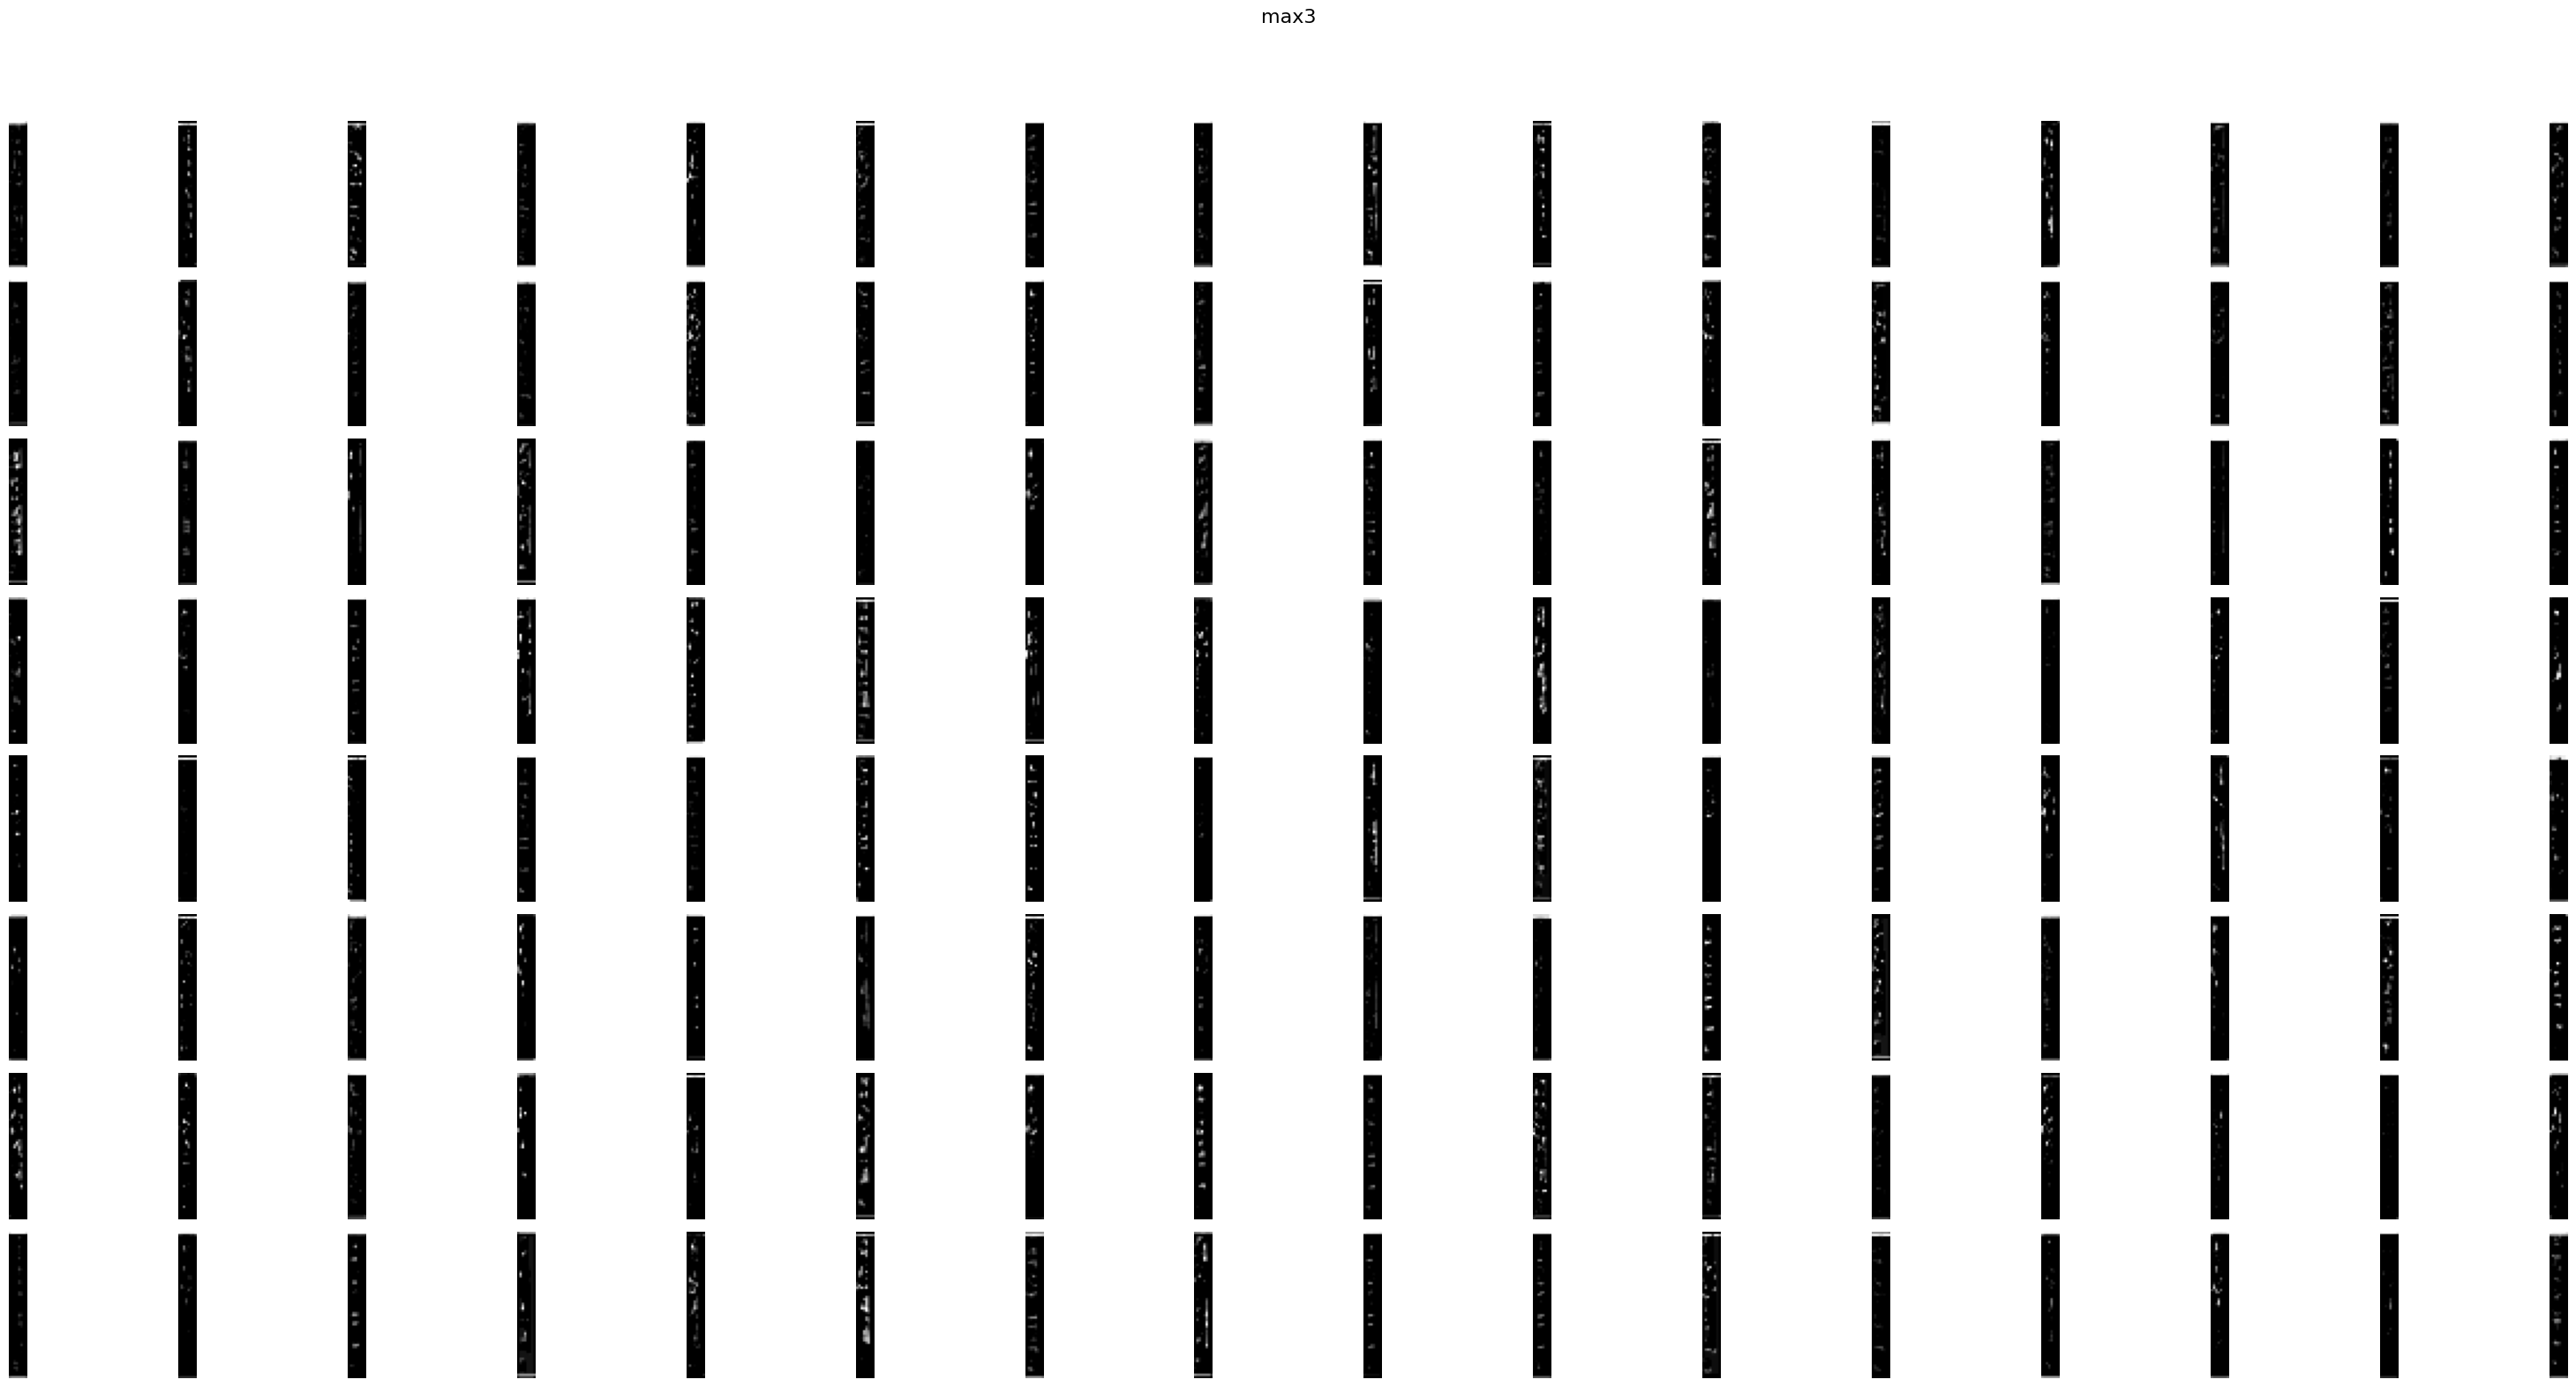

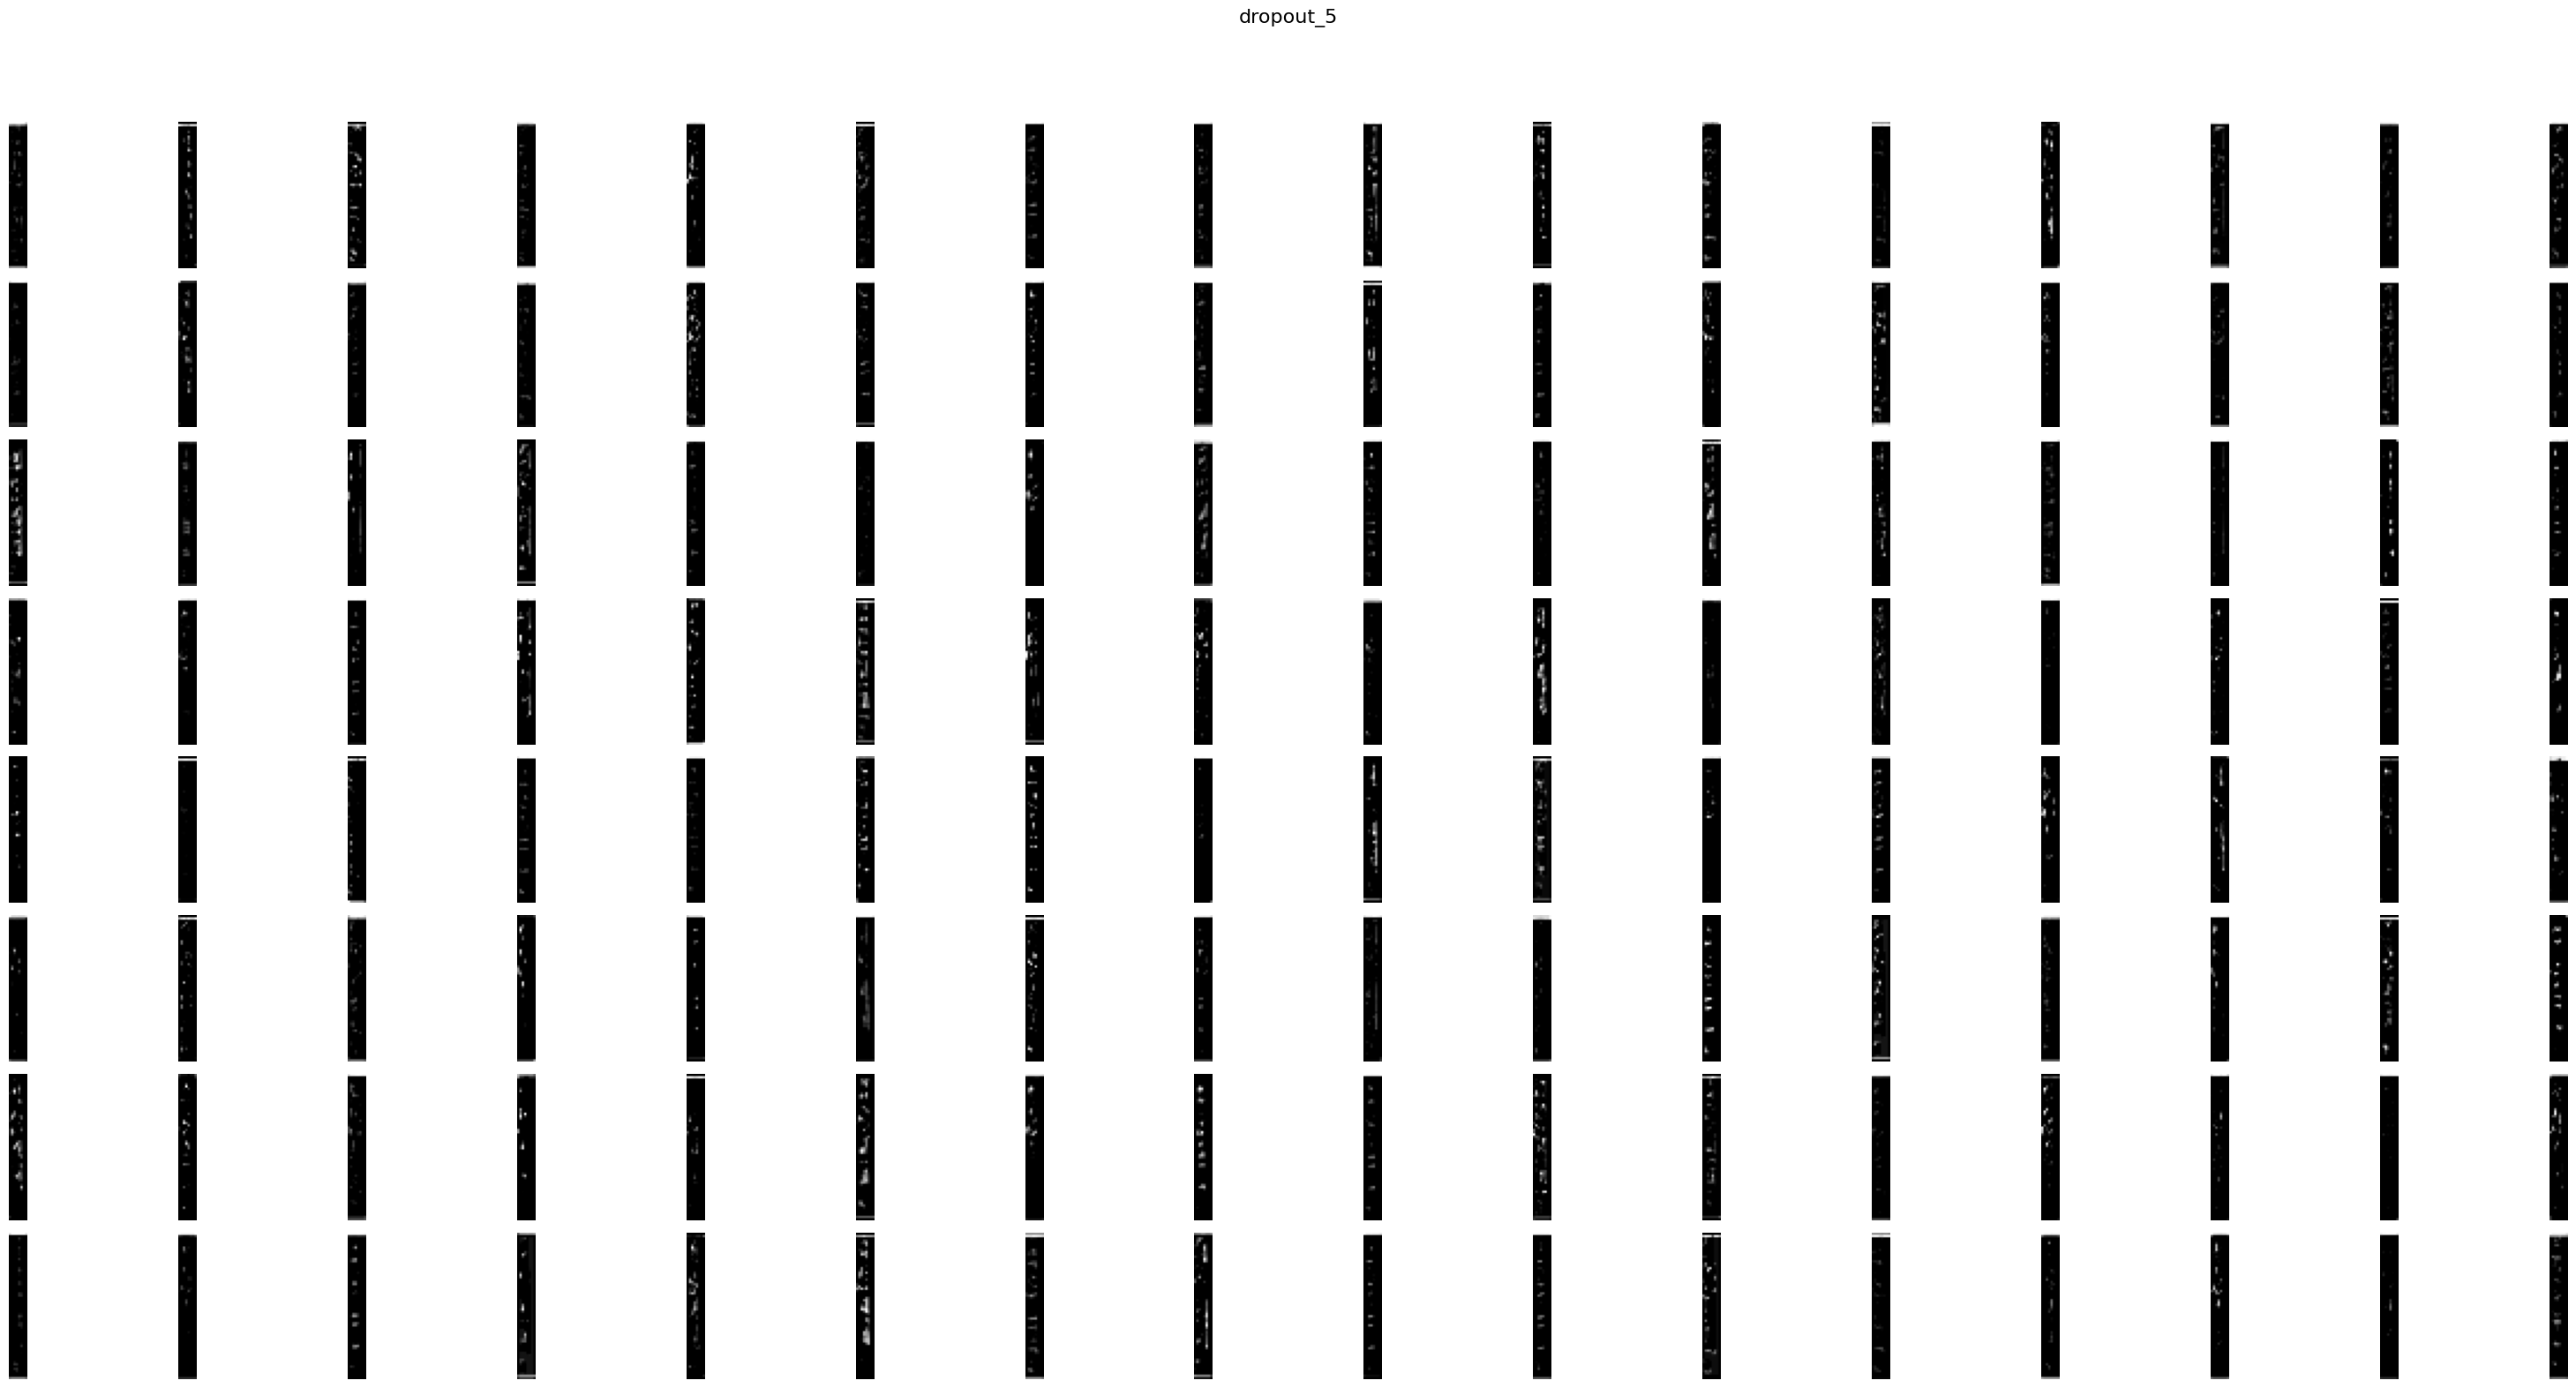

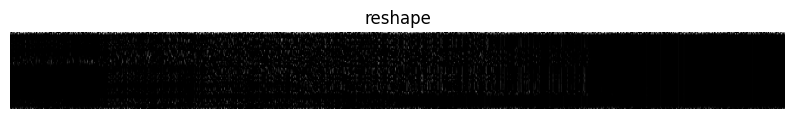

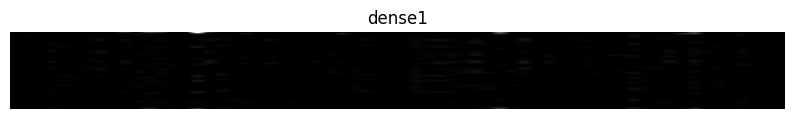

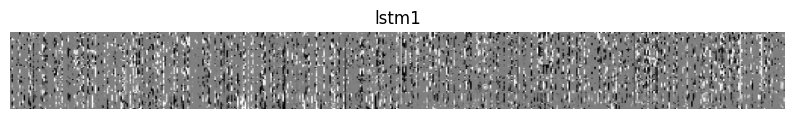

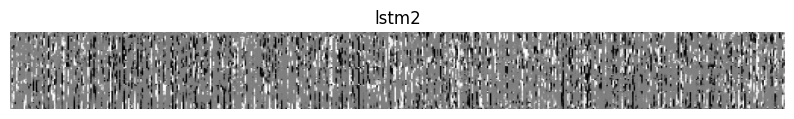

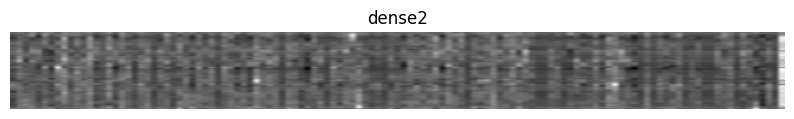

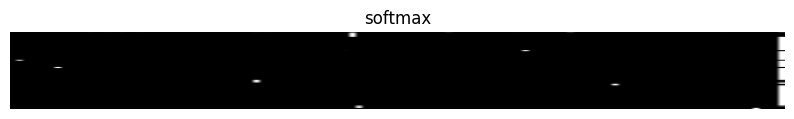

In [53]:
def plot_activations(activations, layer_name):
    activations = np.squeeze(activations)  # Remove single-dimensional entries
    if len(activations.shape) == 2:
        plot_dense_activations(activations, layer_name)
    elif len(activations.shape) == 3:
        plot_conv_activations(activations, layer_name)
    else:
        print(f"Unsupported shape {activations.shape} for layer {layer_name}")

# Function to plot activations for convolutional layers
def plot_conv_activations(activations, layer_name):
    num_filters = activations.shape[-1]
    size = activations.shape[1]
    n_cols = 16 # Number of columns to display
    n_rows = np.ceil(num_filters / n_cols).astype(int)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    fig.suptitle(layer_name, fontsize=16)
    
    for i in range(n_rows * n_cols):
        ax = axes[i // n_cols, i % n_cols]
        if i < num_filters:
            ax.imshow(activations[:, :, i], cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Function to plot activations for dense layers
def plot_dense_activations(activations, layer_name):
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(activations, aspect='auto', cmap='gray')
    ax.set_title(layer_name)
    ax.axis('off')
    plt.show()

# Sample input image from your data
sample_image = image_arr[0]  # Assuming image_arr contains your input images
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Get all layer names
layer_names = [layer.name for layer in model.layers]

# Iterate over each layer and visualize activations
for layer_name in layer_names:
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    activations = intermediate_model.predict(sample_image, verbose=False)
    plot_activations(activations, layer_name)
